# Dependencies
## Imports
Install and import project dependencies

In [78]:
#%pip install matplotlib numpy pandas scikit-learn torch

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from os.path import join
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from typing import Tuple

## MNIST Data Loader

In [80]:
MAGIC_LABELS = 2049
MAGIC_IMAGES = 2051

class MnistDataloader:
    def __init__(self, train_images, train_labels, test_images, test_labels):
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.test_labels = test_labels
        
    def _read_idx_labels(self, path: str) -> np.ndarray:
        """Return labels in an `ndarray` of shape `(n,).`"""
        with open(path, "rb") as f:
            magic, n = struct.unpack(">II", f.read(8))
            if magic != MAGIC_LABELS:
                raise ValueError(f"Labels magic mismatch: expected {MAGIC_LABELS}, got {magic}")
            
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            if labels.size != n:
                raise ValueError(f"Expected {n} labels, found {labels.size}")
            
            return labels

    def _read_idx_images(self, path: str) -> np.ndarray:
        """Return images in an `ndarray` of shape `(n, 28, 28)`."""
        with open(path, "rb") as f:
            magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
            if magic != MAGIC_IMAGES:
                raise ValueError(f"Images magic mismatch: expected {MAGIC_IMAGES}, got {magic}")
            
            pixels = np.frombuffer(f.read(), dtype=np.uint8)
            expected = n * rows * cols
            if pixels.size != expected:
                raise ValueError(f"Expected {expected} pixels, found {pixels.size}")
            
            return pixels.reshape(n, rows, cols)

    def load_data(
        self,
        normalize: bool = False,
        dtype: np.dtype = np.float32
    ) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
        """Return tuples of the train and test data."""
        X_train = self._read_idx_images(self.train_images)
        y_train = self._read_idx_labels(self.train_labels)
        X_test  = self._read_idx_images(self.test_images)
        y_test  = self._read_idx_labels(self.test_labels)

        if normalize:
            X_train = (X_train.astype(dtype) / 255.0)
            X_test  = (X_test.astype(dtype) / 255.0)

        return (X_train, y_train), (X_test, y_test)

---
# Data
## Loading the data

In [81]:
input_path = "./Data"
training_images_filepath = join(input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte")
training_labels_filepath = join(input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte")
test_images_filepath = join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels_filepath = join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [82]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

## Exploratory data analysis and cleaning
Verify that the shapes of the labels and data match.

In [83]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


Ensure that the classes are evenly distributed and there are no duplicates.

In [84]:
labels, counts = np.unique(y_train, return_counts = True)
df = pd.DataFrame({"Label": labels, "Count": counts})
print(df)

print("Total count", counts.sum())

   Label  Count
0      0   5923
1      1   6742
2      2   5958
3      3   6131
4      4   5842
5      5   5421
6      6   5918
7      7   6265
8      8   5851
9      9   5949
Total count 60000


Check for any blank, Nan, or Inf images.

In [85]:
empty_mask = np.all(X_train == 0, axis = (1, 2))
num_empty = np.sum(empty_mask)
print("Blank images:", num_empty)

print("NaNs:", np.isnan(X_train).sum())
print("Infs:", np.isinf(X_train).sum())

Blank images: 0
NaNs: 0
Infs: 0


Plot the images' pixel intensity distribution, mean, and standard deviation.

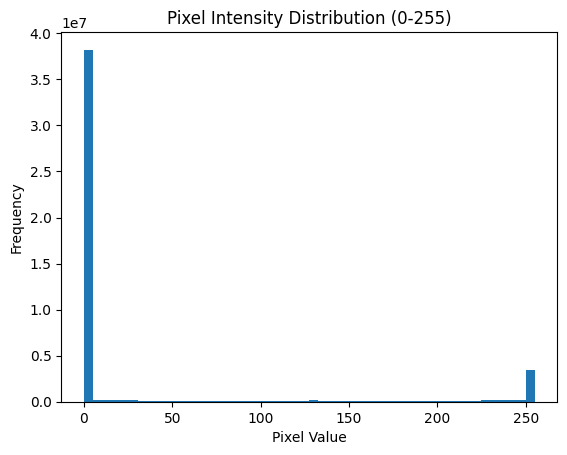

In [86]:
pixels = X_train.flatten()
plt.hist(pixels, bins = 50)
plt.title("Pixel Intensity Distribution (0-255)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

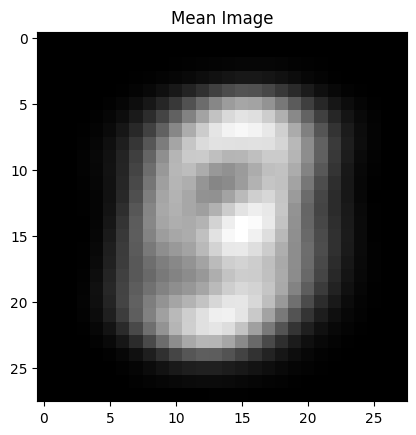

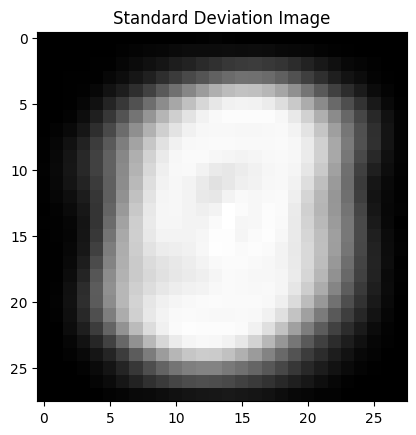

In [87]:
mean_img = X_train.mean(axis = 0)
std_img = X_train.std(axis = 0)

plt.imshow(mean_img, cmap = "gray")
plt.title("Mean Image")
plt.show()

plt.imshow(std_img, cmap = "gray")
plt.title("Standard Deviation Image")
plt.show()

---
# Model

In [88]:
BATCH_SIZE = 32

# Use float tensors for image inputs and long tensors for labels.
torch_X_train = torch.from_numpy(X_train).float()
torch_y_train = torch.from_numpy(y_train).long()  # labels should be long for loss functions like CrossEntropyLoss

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).float()
torch_y_test = torch.from_numpy(y_test).long()

# reshape inputs to (N, 1, 28, 28). They are already floats from the previous cell.
torch_X_train = torch_X_train.view(-1, 1, 28, 28)
torch_X_test = torch_X_test.view(-1, 1, 28, 28)
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train, torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test, torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [89]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 5)
        self.fc1 = nn.Linear(3 * 3 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p = 0.5, training = self.training)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p = 0.5, training = self.training)
        x = x.view(-1,3 * 3 * 64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [90]:
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([32, 10])


In [91]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [92]:
def predict(model):
    predictions = []
    
    for test_imgs, _ in test_loader:
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predictions += torch.max(output, 1)[1]
    
    return predictions

In [93]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap='Oranges', normalize=False):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap=cmap, interpolation='none', aspect='equal')

    # ticks/labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2. if cm.size > 0 else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black',
                    fontsize=9, zorder=3)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

In [94]:
def evaluate(predictions):
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    cm_norm = confusion_matrix(y_test, predictions, normalize = "true")
    
    classes = [str(i) for i in range(10)]
    plot_confusion_matrix(cm, classes)
    plot_confusion_matrix(cm_norm, classes, normalize = True)

In [95]:
fit(cnn, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 15.656803	 Accuracy:6.250%
Epoch : 0 [1600/60000 (3%)]	Loss: 1.873998	 Accuracy:23.100%
Epoch : 0 [3200/60000 (5%)]	Loss: 0.945981	 Accuracy:40.996%
Epoch : 0 [4800/60000 (8%)]	Loss: 1.153195	 Accuracy:51.200%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.388939	 Accuracy:58.567%
Epoch : 0 [8000/60000 (13%)]	Loss: 0.298395	 Accuracy:63.235%
Epoch : 0 [9600/60000 (16%)]	Loss: 0.378111	 Accuracy:66.310%
Epoch : 0 [11200/60000 (19%)]	Loss: 0.320341	 Accuracy:69.427%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.251808	 Accuracy:71.594%
Epoch : 0 [14400/60000 (24%)]	Loss: 0.349120	 Accuracy:73.351%
Epoch : 0 [16000/60000 (27%)]	Loss: 0.236487	 Accuracy:74.620%
Epoch : 0 [17600/60000 (29%)]	Loss: 0.112612	 Accuracy:75.924%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.213646	 Accuracy:77.116%
Epoch : 0 [20800/60000 (35%)]	Loss: 0.262479	 Accuracy:78.091%
Epoch : 0 [22400/60000 (37%)]	Loss: 0.312713	 Accuracy:78.999%
Epoch : 0 [24000/60000 (40%)]	Loss: 0.357574	 Accuracy:79.656%
Epoch 

In [96]:
predictions = predict(cnn)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.98      0.95      1032
           3       0.98      0.94      0.96      1010
           4       0.93      0.97      0.95       982
           5       0.90      0.98      0.94       892
           6       0.97      0.94      0.96       958
           7       0.97      0.94      0.95      1028
           8       0.98      0.92      0.95       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



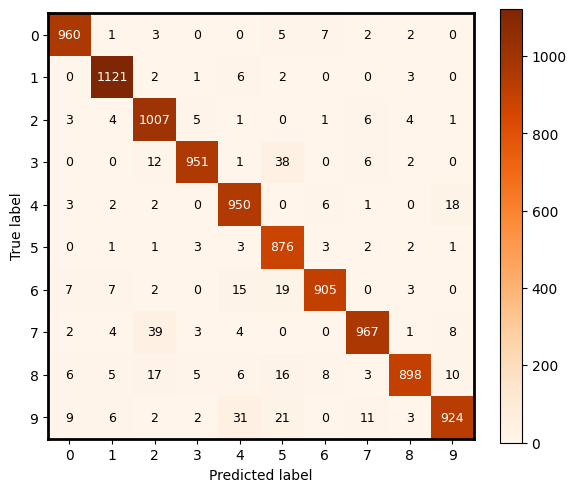

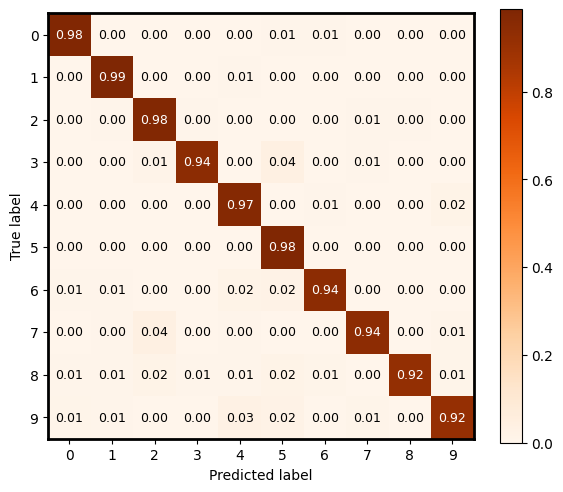

In [97]:
evaluate(predictions)

In [98]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

In [99]:
get_model_size(cnn)

model size: 0.870MB
